# Training and testing with different classifiers

This notebook contains code to apply different ml models to the pre-processed recipe-ingredient dataset. For pre-processing, check the other notebook.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import WordNetLemmatizer
import inflect
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics

In [2]:
# Read the dataset
df = pd.read_json('dataset.json')

Loading the dataset and pre-processing based on understanding of previous EDA.
1. Converting text into lowercase
2. Removing leading and trailing whitespace
3. Removing punctuation, numbers and special characters
4. Replacing plural words with singular versions
5. Lemmatizing the words

In [3]:
wn = WordNetLemmatizer() # lemmatizing instead of stemming to preserve context
p = inflect.engine() # to change to singular instead of stemming

def format_ingredients(ingredient_list):
    formatted = [ing.strip().lower() for ing in ingredient_list]
    alpha = [(''.join(char for char in ing if char.isalpha())) for ing in formatted]
    singular = [p.singular_noun(ing) or ing for ing in alpha]
    lemmatized = [wn.lemmatize(ing) for ing in singular]
    return (', '.join(lemmatized))

df['ingredients_formatted'] = df['ingredients'].apply(lambda x: format_ingredients(x))

### Vectorizing

The ingredient list is already tokenized (as an array of ingredients), but needs to be vectorized (i.e. encoded so as to be able to create feature vectors for the machine learning algorithms to train/test)

Apply TF-IDF vectorization on the dataset, and transform it to a matrix.

In [5]:
tfidf = TfidfVectorizer(stop_words='english', analyzer='word', max_df=0.8, token_pattern=r'\w+')
x_tfidf = tfidf.fit_transform(df['ingredients_formatted'])
print(x_tfidf.shape)

(39774, 6636)


### Cross validation
Asses the performance of models, parameters used here are selected based on experiementation. 
All scripts for random variations/param tuning/grid search that led to selection of these particular values can be found in the [`/scripts`](https://github.com/nutellaweera/ML_Assignment/tree/main/scripts) folder. 

Parameter tuning was done using grid search, selected 'optimal' parameters have been included below for 10-fold cross validation. 

Code is adapted from the 'Batter of Algorithms' pdf included in the Learning Material (revision) section (Phoebe Pring + HI).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df['cuisine'], random_state=42, shuffle=True)

# parameters selected based on experimentation+grid search (see /scripts folder)
models = [ 
    ('KNN', KNeighborsClassifier(n_neighbors=17, metric='euclidean')), 
    ('Logistic Regression', LogisticRegression(max_iter=50, multi_class='multinomial')),
    ('Naive Bayes', MultinomialNB(alpha=0.01)),
    ('Random Forest', RandomForestClassifier(bootstrap=True, criterion='gini', min_samples_split=2, n_estimators=200)),
]

result_tab = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', verbose=0)
    result_tab.append([name, cv_scores.mean(), cv_scores.std(), max(cv_scores), min(cv_scores), cv_scores])

results_df = pd.DataFrame(result_tab, columns=['Name', 'Average', 'Standard deviation', 'Max', 'Min', 'Scores'])

In [29]:
print(results_df)

                  Name   Average  Standard deviation       Max       Min  \
0                  KNN  0.734462            0.005865  0.746564  0.726450   
1  Logistic Regression  0.763996            0.005679  0.774053  0.754274   
2          Naive Bayes  0.739826            0.006532  0.750922  0.726785   
3        Random Forest  0.706235            0.004779  0.710694  0.694268   

                                              Scores  
0  [0.7304726785115655, 0.7294669795507878, 0.736...  
1  [0.7643312101910829, 0.7666778410995642, 0.774...  
2  [0.7375125712370098, 0.7418706000670466, 0.748...  
3  [0.7103586992960107, 0.7086825343613812, 0.710...  


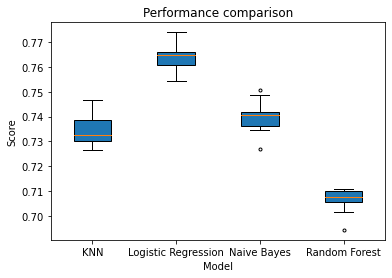

In [42]:
%matplotlib inline
fig, ax = plt.subplots()
plt.boxplot(results_df['Scores'], labels=results_df['Name'], patch_artist=True, sym='.')
ax.set_axisbelow(True)
ax.set_title('Performance comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.savefig('graphs_and_vis/algo_performance.jpeg')
plt.show()

### Model Selection

Logistic regression appears to have the best performance based on 10-fold cross validated accuracy scores. 
Checking other metrics for the selected model.

In [ ]:
lr_clf = LogisticRegression(max_iter=50, multi_class='multinomial')
lr_clf.fit(x_train, y_train)

In [52]:
print(f'Train score: {lr_clf.score(x_train, y_train)}')
print(f'Test score: {lr_clf.score(x_test, y_test)}')

Train score: 0.8152195776064365
Test score: 0.7677996781979083


Generate a confusion matrix (heatmap with sns since this is multiclass and sklearn plot_confusion_matrix doesn't support it)
with predicted and actual cuisine types.

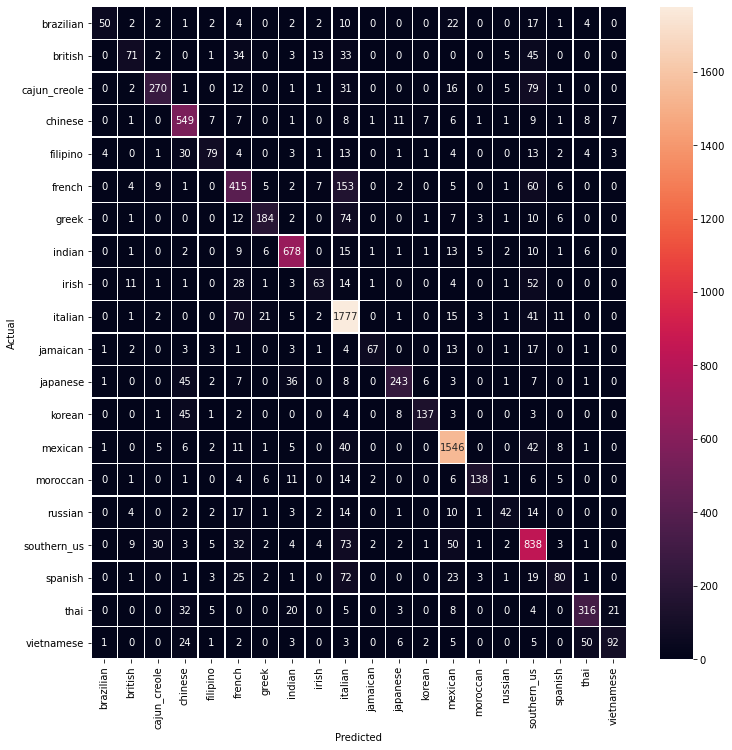

In [76]:
y_pred = lr_clf.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_labels = lr_clf.classes_
cm_df = pd.DataFrame(cm, cm_labels, cm_labels)
plt.figure(figsize=(12,12))
cm_heatmap = sns.heatmap(cm_df, annot=True, fmt='g', linewidths=0.5)
cm_heatmap.set(xlabel='Predicted', ylabel='Actual')

plt.savefig('graphs_and_vis/confusion_matrix.jpeg')